In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 📦 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# 4호선
- 드롭아웃 0.2 > 0.3
- 배치정규화 추가(드롭아웃 0.2)
- 배치정규화 추가(드롭아웃 0.3)

In [ ]:
# 📦 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

df = pd.read_parquet('/content/drive/MyDrive/DL/prepro_data.parquet')
df2 = df[df['호선'] == 4].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df2[col] = df2[col].astype('category')

# 시 (0~23 기준)
df2['시_sin'] = np.sin(2 * np.pi * df2['시'] / 24)
df2['시_cos'] = np.cos(2 * np.pi * df2['시'] / 24)

# 요일 (0~6 기준, 월~일)
df2['요일_sin'] = np.sin(2 * np.pi * df2['요일'] / 7)
df2['요일_cos'] = np.cos(2 * np.pi * df2['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df2.select_dtypes(include=['float64']).columns
df2[float_cols] = df2[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df2.select_dtypes(include=['int64']).columns
df2[int_cols] = df2[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df2.select_dtypes(include=['object']).columns
df2[obj_cols] = df2[obj_cols].astype('category')

df2 = df2.drop(['시', '요일'], axis=1)
df2.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df2.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df2[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------

# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21
batch_size = 32

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

# 딥러닝 모델 구조 정의
model_line4 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.5),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.5),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_line4.compile(loss='mse', optimizer=Adam(0.001))


# 모델 저장 경로 지정 (예: MyDrive/models 폴더)
save_path = '/content/drive/MyDrive/models/Line4_best_model.weights.h5'

# 콜백 설정
callbacks = [
    ModelCheckpoint(filepath=save_path,
        monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
]

# 모델 학습
history_line4 = model_line4.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

<class 'pandas.core.frame.DataFrame'>
Index: 2067984 entries, 2268840 to 13397452
Data columns (total 27 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        category      
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   category      
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        category      
 18  월         int32         
 19  일         int32         
 20  주말        int32         
 21  공휴일       int32         
 22  일사량_측정여부  int32         
 23  시_sin     float32       
 24  시_cos     float32       
 25  요일_sin    float32       
 26  요일_cos    float32       
dtypes: categor

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51698/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2386
Epoch 1: val_loss improved from inf to 0.16631, saving model to /content/drive/MyDrive/models/Line4_best_model.weights.h5
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 386s 7ms/step - loss: 0.2386 - val_loss: 0.1663 - learning_rate: 0.0010
Epoch 2/50
51692/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0946
Epoch 2: val_loss improved from 0.16631 to 0.11557, saving model to /content/drive/MyDrive/models/Line4_best_model.weights.h5
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 387s 7ms/step - loss: 0.0946 - val_loss: 0.1156 - learning_rate: 0.0010
Epoch 3/50
51693/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0822
Epoch 3: val_loss improved from 0.11557 to 0.10666, saving model to /content/drive/MyDrive/models/Line4_best_model.weights.h5
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 386s 7ms/step - loss: 0.0822 - val_loss: 0.1067 - learning_rate: 0.0010
Epoch 4/50
51696/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0771
Epoch 4: val_loss improved from 0.1066

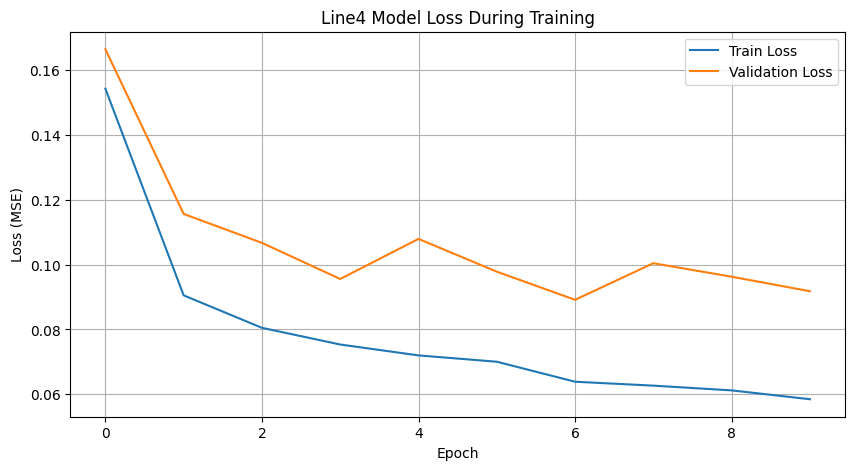

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_line4.history['loss'], label='Train Loss')
plt.plot(history_line4.history['val_loss'], label='Validation Loss')
plt.title('Line4 Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 최고 성능의 가중치 로드
model_line4.load_weights(save_path)

# 검증셋에 대해 예측 수행
pred_scaled = model_line4.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred = ss.inverse_transform(pred_scaled)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

# 평가 지표 계산
mse = mean_squared_error(true, pred)
rmse = np.sqrt(mse)
r2 = r2_score(true, pred)                       # R² Score

# 결과 출력
print(f"✅ 검증 RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

12925/12925 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step
✅ 검증 RMSE: 5.9485
✅ R² Score: 0.9119


In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
model_line4 = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.5),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.5),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
model_line4.compile(loss='mse', optimizer=Adam(0.001))

# 최고 성능의 가중치 로드
model_line4.load_weights(save_path)

# 2) 이전에 저장한 가중치 로드
model_line4.load_weights(save_path)

callbacks = [
    ModelCheckpoint(filepath=save_path,
        monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
]


# 3) 이어서 학습
history_additional = model_line4.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,           # 총 학습 에폭 수
    initial_epoch=10,    # 이어서 시작할 에폭
    callbacks=callbacks
)

Epoch 11/50
51696/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1293
Epoch 11: val_loss improved from inf to 0.09761, saving model to /content/drive/MyDrive/models/model_line4_batch.weights.h5
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 386s 7ms/step - loss: 0.1293 - val_loss: 0.0976 - learning_rate: 0.0010
Epoch 12/50
51696/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0825
Epoch 12: val_loss improved from 0.09761 to 0.09463, saving model to /content/drive/MyDrive/models/model_line4_batch.weights.h5
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 384s 7ms/step - loss: 0.0825 - val_loss: 0.0946 - learning_rate: 0.0010
Epoch 13/50
51693/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0759
Epoch 13: val_loss improved from 0.09463 to 0.08605, saving model to /content/drive/MyDrive/models/model_line4_batch.weights.h5
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 379s 7ms/step - loss: 0.0759 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 14/50
51694/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0717
Epoch 14: val_los

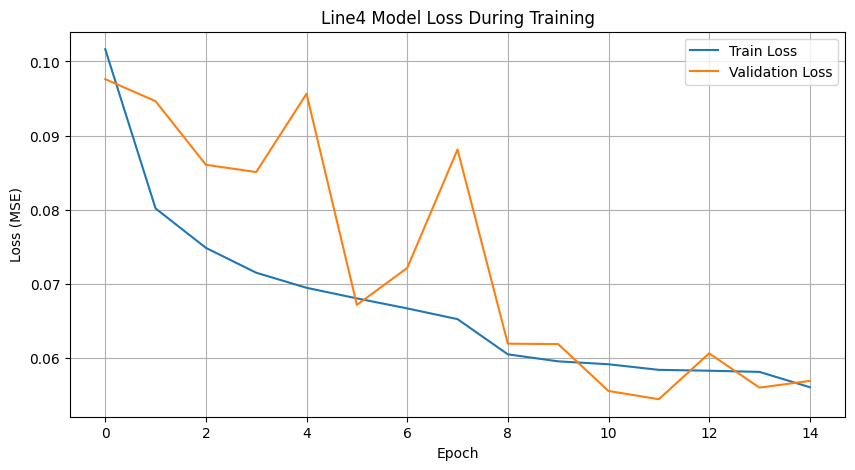

In [ ]:
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_additional.history['loss'], label='Train Loss')
plt.plot(history_additional.history['val_loss'], label='Validation Loss')
plt.title('Line4 Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 최고 성능의 가중치 로드
history_additional = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),  # (timesteps, features)
    LSTM(64, return_sequences=True),   # 첫 번째 LSTM: 시퀀스 출력 유지
    Dropout(0.5),
    LSTM(32),                          # 두 번째 LSTM: 최종 출력만 반환
    Dropout(0.5),
    Dense(1)                           # 예측값 하나 출력 (혼잡도)
])

# 모델 컴파일
history_additional.compile(loss='mse', optimizer=Adam(0.001))
history_additional.load_weights(save_path)

# 검증셋에 대해 예측 수행
pred_scaled = history_additional.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred = ss.inverse_transform(pred_scaled)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

# 평가 지표 계산
mse = mean_squared_error(true, pred)
rmse = np.sqrt(mse)
r2 = r2_score(true, pred)                       # R² Score

# 결과 출력
print(f"✅ 검증 RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

12925/12925 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step
✅ 검증 RMSE: 4.6478
✅ R² Score: 0.9462


# 배치 정규화 추가(드롭아웃0.2)

In [ ]:
# 📦 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

df2 = df[df['호선'] == 4].copy()
cols = ['연도', '호선','상하구분','AWS지점코드']
for col in cols:
    df2[col] = df2[col].astype('category')

# 시 (0~23 기준)
df2['시_sin'] = np.sin(2 * np.pi * df2['시'] / 24)
df2['시_cos'] = np.cos(2 * np.pi * df2['시'] / 24)

# 요일 (0~6 기준, 월~일)
df2['요일_sin'] = np.sin(2 * np.pi * df2['요일'] / 7)
df2['요일_cos'] = np.cos(2 * np.pi * df2['요일'] / 7)

# 월, 일 (1~12, 1~31 기준)
le = LabelEncoder()
df['월'] = le.fit_transform(df['월'])
df['일'] = le.fit_transform(df['일'])

# 1. float64 → float32
float_cols = df2.select_dtypes(include=['float64']).columns
df2[float_cols] = df2[float_cols].astype('float32')

# 2. int64 → int32
int_cols = df2.select_dtypes(include=['int64']).columns
df2[int_cols] = df2[int_cols].astype('int32')

# 3. object(문자열) → category
obj_cols = df2.select_dtypes(include=['object']).columns
df2[obj_cols] = df2[obj_cols].astype('category')

df2 = df2.drop(['시', '요일'], axis=1)
df2.info()

# ✅ [1] 피처 구성 및 전처리 --------------------------------------------------------

# 🎯 타겟 변수 '혼잡도' 제거하여 X 생성
X = df2.drop(['혼잡도', '시간'], axis=1)

# 🔤 범주형 변수 원-핫 인코딩 (첫 번째 카테고리는 drop)
o_h_e_x = pd.get_dummies(X, columns=['연도', '역명', '호선', '상하구분', 'AWS지점코드'], drop_first=True)

# 🔢 X 정규화 (0~1 범위로 스케일링)
mm = MinMaxScaler()
mm_x = mm.fit_transform(o_h_e_x)

# 🎯 y 정규화 (표준화: 평균 0, 표준편차 1)
y = df2[['혼잡도']]  # 2D로 유지
ss = StandardScaler()
ss_y = ss.fit_transform(y)

# ✅ [2] 시계열 학습/검증 데이터 분할 --------------------------------------------------

# 전체의 80%를 학습용, 나머지 20%를 검증용으로 사용
split_index = int(len(mm_x) * 0.8)

train_x = mm_x[:split_index]
train_y = ss_y[:split_index]

val_x = mm_x[split_index:]
val_y = ss_y[split_index:]

# ✅ [3] 시계열 데이터 생성 -----------------------------------------------------------

# 과거 21시간 데이터를 기반으로 예측
sequence_length = 21
batch_size = 32

# TimeseriesGenerator를 통해 시계열 학습/검증셋 생성
train_gen = TimeseriesGenerator(train_x, train_y, length=sequence_length, batch_size=batch_size)
val_gen   = TimeseriesGenerator(val_x, val_y, length=sequence_length, batch_size=batch_size)

# ✅ [4] LSTM 모델 정의 및 학습 --------------------------------------------------------

from tensorflow.keras.layers import BatchNormalization

model_line4_batch = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),
    LSTM(64, return_sequences=True),
    BatchNormalization(),       # 추가
    Dropout(0.2),
    LSTM(32),
    BatchNormalization(),       # 추가
    Dropout(0.2),
    Dense(1)
])


# 모델 컴파일
model_line4_batch.compile(loss='mse', optimizer=Adam(0.001))


# 모델 저장 경로 지정 (예: MyDrive/models 폴더)
save_path = '/content/drive/MyDrive/models/model_line4_batch.weights.h5'

# 콜백 설정
callbacks = [
    ModelCheckpoint(filepath=save_path,
        monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
]

# 모델 학습
history_line4_batch = model_line4_batch.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

<class 'pandas.core.frame.DataFrame'>
Index: 2067984 entries, 2268840 to 13397452
Data columns (total 27 columns):
 #   Column    Dtype         
---  ------    -----         
 0   시간        datetime64[ns]
 1   호선        category      
 2   역번호       int32         
 3   역명        category      
 4   상하구분      category      
 5   AWS지점코드   category      
 6   기온        float32       
 7   풍향        float32       
 8   풍속        float32       
 9   일강수량      float32       
 10  시간강수량     float32       
 11  상대습도      float32       
 12  체감온도      float32       
 13  혼잡도       float32       
 14  승차총승객수    float32       
 15  하차총승객수    float32       
 16  미세먼지      float32       
 17  연도        category      
 18  월         int32         
 19  일         int32         
 20  주말        int32         
 21  공휴일       int32         
 22  일사량_측정여부  int32         
 23  시_sin     float32       
 24  시_cos     float32       
 25  요일_sin    float32       
 26  요일_cos    float32       
dtypes: categor

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51694/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5693
Epoch 1: val_loss improved from inf to 0.49566, saving model to /content/drive/MyDrive/models/model_line4_batch.weights.h5
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 489s 9ms/step - loss: 0.5692 - val_loss: 0.4957 - learning_rate: 0.0010
Epoch 2/50
51696/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4552
Epoch 2: val_loss improved from 0.49566 to 0.44593, saving model to /content/drive/MyDrive/models/model_line4_batch.weights.h5
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 478s 9ms/step - loss: 0.4552 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 3/50
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4487
Epoch 3: val_loss did not improve from 0.44593
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 480s 9ms/step - loss: 0.4487 - val_loss: 0.5926 - learning_rate: 0.0010
Epoch 4/50
51699/51699 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4437
Epoch 4: val_loss improved from 0.44593 to 0.41257, saving model to /content/drive/MyDrive/models/model_line4_batch

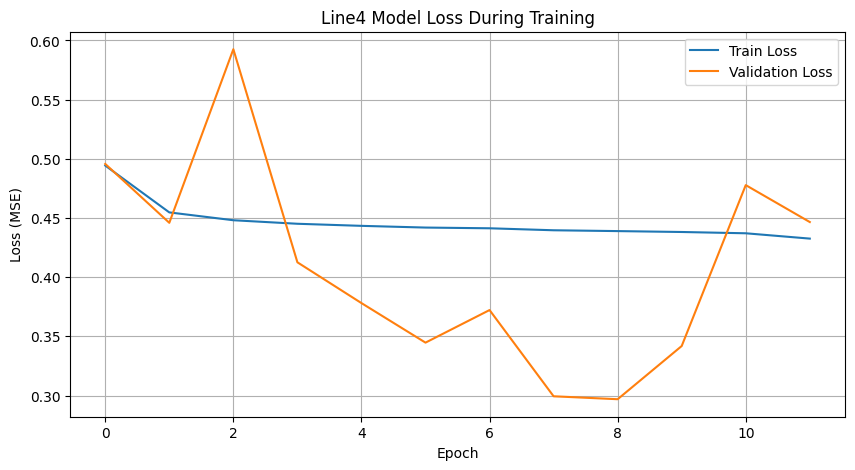

In [ ]:
# 학습에 쓰인 데이터 한 달 정해서
# 📊 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(history_line4_batch.history['loss'], label='Train Loss')
plt.plot(history_line4_batch.history['val_loss'], label='Validation Loss')
plt.title('Line4 Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ✅ [5] 예측 및 평가 ---------------------------------------------------------------
save_path = '/content/drive/MyDrive/models/model_line4_batch.weights.h5'

model_line4_batch = Sequential([
    Input(shape=(sequence_length, train_x.shape[1])),
    LSTM(64, return_sequences=True),
    BatchNormalization(),       # 추가
    Dropout(0.2),
    LSTM(32),
    BatchNormalization(),       # 추가
    Dropout(0.2),
    Dense(1)
])


# 모델 컴파일
model_line4_batch.compile(loss='mse', optimizer=Adam(0.001))

# 최고 성능의 가중치 로드
model_line4_batch.load_weights(save_path)

# 검증셋에 대해 예측 수행
pred_scaled = model_line4_batch.predict(val_gen)

# 정규화 해제 (역정규화) → 실제 혼잡도 단위로 복원
pred = ss.inverse_transform(pred_scaled)

# 실제 y도 시계열 슬라이싱 기준에 맞게 자르기
true = ss.inverse_transform(val_y[sequence_length:])

# 평가 지표 계산
mse = mean_squared_error(true, pred)
rmse = np.sqrt(mse)
r2 = r2_score(true, pred)                       # R² Score

# 결과 출력
print(f"✅ 검증 RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

In [ ]:
# # 2) 이전에 저장한 가중치 로드
# save_path = '/content/drive/MyDrive/models/Line4_best_model.weights.h5'
# model.load_weights(save_path)

# callbacks = [
#     ModelCheckpoint(filepath=save_path,
#         monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
#         EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
#         ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
# ]


# # 3) 이어서 학습
# history_additional = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=50,           # 총 학습 에폭 수
#     initial_epoch=,    # 이어서 시작할 에폭
#     callbacks=callbacks
# )